In [ ]:
# Tutorials from which we took some code (adapted):
# - https://nextjournal.com/gkoehler/pytorch-mnist
# - https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118
# - for cross-validation: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md

In [2]:
# Set constants
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_TEST = 1000 # I don't think this actually matters

K_FOLDS = 2 #5

NUMBER_OF_EPOCHS = 2
LEARNING_RATE = 0.05
MOMENTUM = 0

USE_PNG_FORMAT = False

In [4]:
import exercise2_config as config
import torch
import numpy as np
import pandas as pd
import os
from datetime import datetime
from PIL import Image
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader
import readers

torch.backends.cudnn.enabled = False
seed = round(datetime.timestamp(datetime.now()))
torch.manual_seed(seed)

print(f'Seed = {seed}')


def BuildDataLoadersFromCsvFiles(permutated):
  if(permutated):
    train_images = pd.read_csv("../mnist/trainOutput.csv", header=None)
    test_images = pd.read_csv("../mnist/testOutput.csv", header=None)
  else:
    train_images = pd.read_csv(config.TRAIN_DATA_FILE, header=None)
    test_images = pd.read_csv(config.TEST_DATA_FILE, header=None)

  train_data = np.array(train_images.iloc[:,1:])
  train_labels = np.array(train_images.iloc[:,0])
  test_data = np.array(test_images.iloc[:,1:])
  test_labels = np.array(test_images.iloc[:,0])

  train_data = np.reshape(train_data, (len(train_data), 1, 28, 28))
  # Normalize the data
  train_data = torch.from_numpy(train_data).float()/255
  train_labels = torch.from_numpy(np.array(train_labels))
  train_set = TensorDataset(train_data, train_labels)

  test_data = np.reshape(test_data, (len(test_data), 1, 28, 28))
  # Normalize the data
  test_data = torch.from_numpy(test_data).float()/255
  test_labels = torch.from_numpy(np.array(test_labels))
  test_set = TensorDataset(test_data, test_labels)
  
  train_loader = DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
  test_loader = DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True)
  return train_loader, test_loader


# We first import the data and convert them to a torch version
def BuildDataLoaders(use_png_format=USE_PNG_FORMAT):
  if use_png_format:
    readers.ReadFromPngFiles()
    return BuildDataLoadersFromCsvFiles(use_png_format)
  return BuildDataLoadersFromCsvFiles(use_png_format)


original_train_loader, original_test_loader = BuildDataLoaders()


Seed = 1653299500


In [5]:
%load_ext autoreload
%autoreload 2
import model_task2c
import torch.nn.functional as F
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler


# Needed in order to detect if any values become nan
# This was the case at some point, but it's not really useful anymore.
torch.autograd.set_detect_anomaly(True) 


# Compute the accuracy of the model on the given data set 
# and returns the loss. 
def ComputeAccuracy(loader, data_label, model, loss_func='cross_entropy'):
    model.eval()
    total_loss = 0
    correct = 0
    number_of_tests = 0

    with torch.no_grad():
        for _, (data, label) in enumerate(loader):
            output = model(data)
            
            if loss_func == 'cross_entropy':
                total_loss += F.cross_entropy(output, label, reduction='sum').item()
            else:
                total_loss += F.nll_loss(output, label, reduction='sum').item()

            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(label.data.view_as(pred)).sum()
            number_of_tests += len(data)

    
    average_loss = total_loss / number_of_tests
    accuracy = 100. * correct / number_of_tests
    print(f'Accuracy {data_label}: {correct}/{number_of_tests} ({accuracy:.2f}%)')
    print(f'Average loss: {average_loss:.4f}\n')

    return accuracy, average_loss


# Trains a model using the given train dataset and returns the following (in this order):
# - model
# - train_loss_per_epoch
# - test_loss_per_epoch
# - train_accuracy_per_epoch
# - test_accuracy_per_epoch
# - learning_rate_per_epoch
def train(train_loader, test_loader, number_of_epochs, learning_rate, loss_func='cross_entropy'):
    # Initialize classifier stuff
    model = model_task2c.PR_CNN()   # initialization of the model
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=MOMENTUM)

    train_loss_per_epoch = []
    train_accuracy_per_epoch = []
    test_loss_per_epoch = []
    test_accuracy_per_epoch = []
    learning_rate_per_epoch = []

    #To optimize the learning rate with LambdaLR
    #From https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling/notebook
    # The learning rate will be 10% smaller from one epoch to another
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=(lambda factor: 0.9 ** factor))

    for epoch in range(number_of_epochs):
        print(f'Epoch {epoch + 1}')
        current_learning_rate = round(optimizer.param_groups[0]["lr"],3)
        print(f'Learning Rate: {current_learning_rate}')
        learning_rate_per_epoch.append(current_learning_rate)

        model.train()  # activation of the train mode

        for _, (data, label) in enumerate(train_loader):
            # Set gradients to 0. PyTorch accumulates the gradients 
            # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
            optimizer.zero_grad()

            # forward + backward + optimize
            output = model(data)

            if loss_func == 'cross_entropy':
                loss = F.cross_entropy(output, label)
            else:
                loss = F.nll_loss(output, label)

            loss.backward()
            optimizer.step()
        
        # Compute the accuracy of the model at the end of each epoch
        train_accuracy, train_loss = ComputeAccuracy(train_loader, 'train', model, loss_func)
        train_loss_per_epoch.append(train_loss)
        train_accuracy_per_epoch.append(train_accuracy)
        
        test_accuracy, test_loss = ComputeAccuracy(test_loader, 'test', model, loss_func)
        test_loss_per_epoch.append(test_loss)
        test_accuracy_per_epoch.append(test_accuracy)

        scheduler.step()

    return model, train_loss_per_epoch, test_loss_per_epoch, train_accuracy_per_epoch, test_accuracy_per_epoch, learning_rate_per_epoch


# Trains a model using the given train dataset and returns the following (in this order):
# - model
# - train_loss_per_epoch
# - test_loss_per_epoch
# - train_accuracy_per_epoch
# - test_accuracy_per_epoch
# - learning_rate_per_epoch
def TrainWithoutCrossValidation(train_loader, test_loader):
    return train(train_loader, test_loader, NUMBER_OF_EPOCHS, LEARNING_RATE)


# Returns the average accuracy obtained on the validation set for each fold.
def TrainWithCrossValidationAndFixedParams(train_loader, number_of_epochs, learning_rate):
    kfold = KFold(n_splits=K_FOLDS, shuffle=True)
    # Sum of accuracies obtained on the validation sets for each fold
    sum_accuracy_validation_set = 0

    for fold, (train_ids, validation_ids) in enumerate(kfold.split(train_loader.dataset)):
        print(f'Fold {fold + 1}')

        # Sample elements randomly from a given list, no replacement.
        train_subsampler = SubsetRandomSampler(train_ids)
        validation_subsampler = SubsetRandomSampler(validation_ids)
        
        fold_train_loader = DataLoader(train_loader.dataset, batch_size=BATCH_SIZE_TRAIN, sampler=train_subsampler)
        fold_validation_loader = DataLoader(train_loader.dataset, batch_size=BATCH_SIZE_TEST, sampler=validation_subsampler)

        _, _, _, _, fold_test_accuracy_per_epoch, _ = \
            train(fold_train_loader, fold_validation_loader, number_of_epochs, learning_rate)     
        # Add final accuracy
        sum_accuracy_validation_set += fold_test_accuracy_per_epoch[-1]
        
        print('--------------------------------------------------')   

    return sum_accuracy_validation_set / K_FOLDS


# Trains a model using the given train dataset and returns the following (in this order):
# - model
# - train_loss_per_epoch
# - test_loss_per_epoch
# - train_accuracy_per_epoch
# - test_accuracy_per_epoch
# - learning_rate_per_epoch
def TrainWithCrossValidation(train_loader, test_loader):
    best_accuracy = 0
    number_of_epochs_for_best_accuracy = None
    learning_rate_for_best_accuracy = None

    
    # Identify the best number of epochs and learning rate
    for number_of_epochs in [10, 15, 20]:
        for learning_rate in [0.01, 0.05, 0.1]:
            print(f'NUMBER OF EPOCHS = {number_of_epochs}, LEARNING RATE = {learning_rate}')

            average_accuracy_cross_validation = \
                TrainWithCrossValidationAndFixedParams(train_loader, number_of_epochs, learning_rate)
            print(f'average_accuracy_cross_validation = {average_accuracy_cross_validation}')

            if average_accuracy_cross_validation > best_accuracy:
                best_accuracy = average_accuracy_cross_validation
                number_of_epochs_for_best_accuracy = number_of_epochs
                learning_rate_for_best_accuracy = learning_rate

            print('==================================================')   

    # Train a model on the best number of epochs and learning rate
    print(f'BEST NUMBER OF EPOCHS = {number_of_epochs_for_best_accuracy}, BEST LEARNING RATE = {learning_rate_for_best_accuracy}')
    return train(train_loader, test_loader, number_of_epochs_for_best_accuracy, learning_rate_for_best_accuracy)

In [ ]:
# Train the model

# Without cross validation 
# cnn_model, train_loss_per_epoch, test_loss_per_epoch, train_accuracy_per_epoch, test_accuracy_per_epoch, learning_rate_per_epoch = \
#   TrainWithoutCrossValidation(original_train_loader, original_test_loader)

# With cross validation
cnn_model, train_loss_per_epoch, test_loss_per_epoch, train_accuracy_per_epoch, test_accuracy_per_epoch, learning_rate_per_epoch = \
  TrainWithCrossValidation(original_train_loader, original_test_loader)

In [14]:
# FOR COMPETITION

cnn_model, train_loss_per_epoch, test_loss_per_epoch, train_accuracy_per_epoch, test_accuracy_per_epoch, learning_rate_per_epoch = \
  train(original_train_loader, original_test_loader, 15, 0.13)

Epoch 1
Learning Rate: 0.13
Accuracy train: 57125/60000 (95.21%)
Average loss: 0.2131

Accuracy test: 9514/10000 (95.14%)
Average loss: 0.2076

Epoch 2
Learning Rate: 0.117
Accuracy train: 57654/60000 (96.09%)
Average loss: 0.1589

Accuracy test: 9604/10000 (96.04%)
Average loss: 0.1532

Epoch 3
Learning Rate: 0.105
Accuracy train: 58610/60000 (97.68%)
Average loss: 0.1322

Accuracy test: 9755/10000 (97.55%)
Average loss: 0.1288

Epoch 4
Learning Rate: 0.095
Accuracy train: 58714/60000 (97.86%)
Average loss: 0.1182

Accuracy test: 9756/10000 (97.56%)
Average loss: 0.1164

Epoch 5
Learning Rate: 0.085
Accuracy train: 58953/60000 (98.25%)
Average loss: 0.0899

Accuracy test: 9795/10000 (97.95%)
Average loss: 0.0932

Epoch 6
Learning Rate: 0.077
Accuracy train: 59014/60000 (98.36%)
Average loss: 0.0808

Accuracy test: 9807/10000 (98.07%)
Average loss: 0.0806

Epoch 7
Learning Rate: 0.069
Accuracy train: 59086/60000 (98.48%)
Average loss: 0.0781

Accuracy test: 9802/10000 (98.02%)
Average 

In [15]:
# FOR COMPETITION

competition_images = pd.read_csv(config.COMPETITION_FILE, header=None)

competition_data = np.array(competition_images.iloc[:,:])

competition_data = np.reshape(competition_data, (len(competition_data), 1, 28, 28))
# Normalize the data
competition_data = torch.from_numpy(competition_data).float()/255
competition_set = TensorDataset(competition_data, competition_data)
  
competition_loader = DataLoader(competition_set, batch_size=10000, shuffle=True)

for _, (data, label) in enumerate(competition_loader):
  output = cnn_model(data)
  competition_predicted_labels = output.data.max(1, keepdim=True)[1]


with open(config.COMPETITION_OUTPUT_CNN, 'w') as f:
  for label in competition_predicted_labels:
    f.write(str(label[0].tolist()))
    f.write('\n')

In [ ]:
import os


# Saves a model to a file in the same directory as this script.
def SaveModel(model):
  filename = os.path.join(os.path.abspath(''), 'cnn_model.pt')
  torch.save(model.state_dict(), filename)
  pass


# Loads a model from a file.
def LoadModel(filename=os.path.join(os.path.abspath(''), 'cnn_model.pt')):
  model = model_task2c.PR_CNN()
  model.load_state_dict(torch.load(filename))
  return model


# SaveModel(cnn_model)
# cnn_model = LoadModel()

# Results

Plot showing the accuracy and loss on the training and the test set with respect to the training epochs, for the best configuration found.

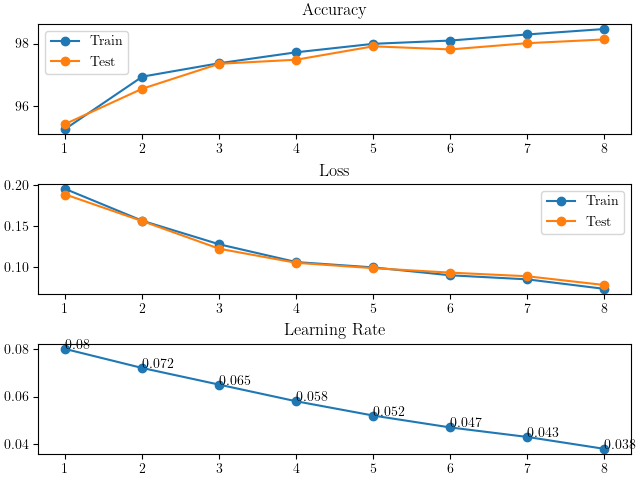

In [ ]:
# You need to install ipympl to make this work
%matplotlib widget
import matplotlib
from matplotlib import pyplot as plt
import os


epochs = [i for i in range(1, len(train_accuracy_per_epoch) + 1)]
fig, axes = plt.subplots(3, 1, constrained_layout=True)
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False


# Show accuracy
axes[0].plot(epochs, train_accuracy_per_epoch,'-o')
axes[0].plot(epochs, test_accuracy_per_epoch, '-o')
axes[0].set_xticks(epochs)
axes[0].legend(['Train', 'Test'])
axes[0].set_title('Accuracy')


# Show loss
axes[1].plot(epochs, train_loss_per_epoch,'-o')
axes[1].plot(epochs, test_loss_per_epoch, '-o')
axes[1].set_xticks(epochs)
axes[1].legend(['Train', 'Test'])
axes[1].set_title('Loss')


# Show learning rate per epoch
axes[2].plot(epochs, learning_rate_per_epoch,'-o')
axes[2].set_xticks(epochs)
axes[2].set_title('Learning Rate')
for epoch in epochs:
  # Epochs start at 1, indexes at 0
  axes[2].text(epoch, learning_rate_per_epoch[epoch - 1], learning_rate_per_epoch[epoch - 1])
  pass

plt.show()


# Save as png
plot_filename = os.path.join(os.path.abspath(''), 'cnn_model_plot_8.png')
plt.savefig(plot_filename)


# Save as pfg
# Code taken from here: https://timodenk.com/blog/exporting-matplotlib-plots-to-latex/
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })
# plot_filename = os.path.join(os.path.abspath(''), 'cnn_model_plot_8.pgf')
# plt.savefig(plot_filename)

In [ ]:
print(cnn_model)
print(f'Batch size = {BATCH_SIZE_TRAIN}')
print(f'Number of epochs = {len(train_accuracy_per_epoch)}')
print(f'Learning rate at start = {learning_rate_per_epoch[0]}')

# Compute the accuracy of the model on the test dataset
ComputeAccuracy(original_test_loader, 'test', cnn_model)

print(train_accuracy_per_epoch)
print(test_accuracy_per_epoch)


print(train_loss_per_epoch)
print(test_loss_per_epoch)